## Exploratory Data Analysis

In [291]:
import pandas as pd
import numpy as np
from summarytools import dfSummary
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, auc, roc_auc_score, f1_score, confusion_matrix, accuracy_score

from category_encoders import CatBoostEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from tabulate import tabulate

import optuna as opt # hyperparameter tuning

from warnings import filterwarnings
filterwarnings('ignore')

In [275]:
train = pd.read_csv("data/customer_churn_dataset-training-master.csv")

In [276]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  object 
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  object 
 8   Contract Length    440832 non-null  object 
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB


In [277]:
train.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [278]:
train.describe()

,CustomerID,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
count,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000
mean,225398.667955,39.373153,31.256336,15.807494,3.604437,12.965722,631.616223,14.480868,0.567107
std,129531.918550,12.442369,17.255727,8.586242,3.070218,8.258063,240.803001,8.596208,0.495477
min,2.000000,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,113621.750000,29.000000,16.000000,9.000000,1.000000,6.000000,480.000000,7.000000,0.000000
50%,226125.500000,39.000000,32.000000,16.000000,3.000000,12.000000,661.000000,14.000000,1.000000
75%,337739.250000,48.000000,46.000000,23.000000,6.000000,19.000000,830.000000,22.000000,1.000000
max,449999.000000,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


In [279]:
train.isnull().sum()

CustomerID           1
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64

In [280]:
train = train.dropna()

In [281]:
train[train.duplicated()]

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn


In [282]:
train.nunique()

CustomerID           440832
Age                      48
Gender                    2
Tenure                   60
Usage Frequency          30
Support Calls            11
Payment Delay            31
Subscription Type         3
Contract Length           3
Total Spend           68363
Last Interaction         30
Churn                     2
dtype: int64

In [283]:
dfSummary(train)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,CustomerID[float64],Mean (sd) : 225398.7 (129531.9)min < med < max:2.0 < 226125.5 < 449999.0IQR (CV) : 224117.5 (1.7),"440,832 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACfElEQVR4nO3YP6/SYBiG8ecFDpQ/lhCOsHVxNHFgZPEb+GFd3SSBL8Dg4sRCSAiUUA+hVFxkcBBoK+254/WbzwNP+l5py3Hn89mA165S9gLAPWplL4A/OeeaZlbP8REVM/tZwqyZ2fF8Pr/kmP+rm6HmvHAPW/yWf3Dghe/unGv2+/1Pvu/3sswnSfIURdG7TqfzvVKpxEXNXux2u41z7vMjrtvVUPNeuEcufk3evc3Mttvt3jn3xcwOGcaz3pn8TqczGI/Hu263m/p7F4tFbz6fvx2NRt+Gw+GmqFkzszAMvel02luv13UzKzZUM6v7vt8bj8cvaS9cGIbeZDIZrNfrZ+fcLuN+pRz4crl8M5vNPgZB8FytVlPN57kzxXHsJUnyvtFofB0MBj/SbW222WyaZmbtdvuQdj7P7EWSJL6Z+c65LONXn2B3vaN2u93Uy0dR9BTH8YcgCKppD9us/AP3PK81Go0ORd6Zfs+2TqdTNd3G5ct73reevg/7MXU8HmtZD9vsdRx40Xemy6yiPOd9z2vDw3/1Z32U/K8Hri7Hq8PVM+P/qJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBQu+ePwjD00n7wfr/3zMyiKPJWq1WryHnV71bdO+/8PX39Ai9SYfXEvrAfAAAAAElFTkSuQmCC"">",0(0.0%)
2,Age[float64],Mean (sd) : 39.4 (12.4)min < med < max:18.0 < 39.0 < 65.0IQR (CV) : 19.0 (3.2),48 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACtklEQVR4nO3csW7aQBzH8f9BiBxAthAq2Vg6VurAyEP0YfsIHfIEGbpkYosUIRBuEMbQpUhEpWDuoPhnfz/7BUf6GnM+n912uzWg7Bq3PgCgiLtbH0AVOecezOzec/hqu92+X/J4qoBQL8w599Dv97/FcdzzGT+fz6fOue/E+hGhXt59HMe98Xj8niTJ8pyBs9ksenp66r29vd2bGaHuIdQrSZJkORgMfnkMfbj4wVQAkylI4Bv1HwImRPFms2ld+njqjlAPCJkQZVkW5Xn+Zblc/jAzn0s/DiDUw7wnRJPJpPf8/Nxer9fNax1cHRHqET4Toul0ymToCphMQQKhQkKpL/0sRWKntKHWdSkyz/OWmcXOOd8/UckTtLShWg2XItM0bWVZ9nU4HDabzeZZ//OO6gl6SplDNbN6LUWuVqu7KIrao9Fo+fj4OD13vOoJWsRVQw38jVnbFZ5Op+N7cpoJnqBFXC3U0N+YrPBg3zW/Ub1/Y5qxwoOPToYa+nBGkiRTn8sYKzzYdzRUHs5AWZz6RpV9OCPwfmRtJ3JlVeg3qtrDGaH3I7kalE/p76P6CL0feeurAf5WyVB3fO9HMpErH56eggRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChYRKP+ZXR4E7Gxpmtgn4+JDxR9/wQqgVErKzIc/zVpqmn7vd7kuj0cjO/ezQ8afe8EKoFRKys+HProZPo9HoZ8CuCK/xRd7wQqgV5LOzYberIXRXRMBbXo7uqmAyBQmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmF3pQym82ic//wYrGIzMzSNI1eX1/b/3O86merHnfo+CJ9/QanWJbjhD2qpQAAAABJRU5ErkJggg=="">",0(0.0%)
3,Gender[object],1. Male2. Female,"250,252 (56.8%)190,580 (43.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABNklEQVR4nO3bQWqDQByF8TdFQrMZEcHDeIgetoeY24g4iyZkM13URTzAvBH7/U7wRz6EBF8opQhwCJLukm6tD7mwVynl0fqIM+jGcfyKMQ6tD7mqnPMaQvgmOKmLMQ7zPD/6vn+2PuZqtm37TCkNy7LcJBGbJPV9/5ym6af1MRd1b33AWXy0PgD/B7HBhthgQ2ywITbYEBtsiA02xAYbYoMNscGG2GBDbLAhNtgQG2yIDTad9PeRX+tDrojnetTlnNeU0iA+8qsi57xKerW+4wwYvNTH4GUXmPLBhTfbEW+hipjyvWF2VxdTvh2zu/qY8h3xi7wi/tSFDbHBhthgQ2ywITbYEBtsiA02xAYbYoMNscGG2GBDbLAhNtgQG2yIDTZM+XY8g/qY8r1hdlcXg5cjBi8V/QIKW2rfxJVRAgAAAABJRU5ErkJggg=="">",0(0.0%)
4,Tenure[float64],Mean (sd) : 31.3 (17.3)min < med < max:1.0 < 32.0 < 60.0IQR (CV) : 30.0 (1.8),60 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACmElEQVR4nO3Yv2/aQBiH8fcgRMeP2iJQsrF0jNQBKUuWbh37x3bt1gGkzgxdOmVBkSICwg3CGLq0VZYk2GdMvtLzWZM3d+QeIzi33+8NeOtqp94AcIizU28A5XLONc3svOD4Zr/fP77FtQn1GYH/9JqZ7U4w6y8uLj7HcdwuMvzw8LByzn0zs3XVay+Xy7lz7utzsR411MDDNgt8wotyzjV7vd6XKIq6eWezLGskSfKh0+n8qtVqaVWzZmZpmnozu7q+vv7R7/eXeWZns9m7yWTyaTgc9uv1eu5QQ9ZeLBZ+PB537+/vz82s2lBDDvuf156yIzqPoqh7c3PzGMdxrkO7vb3tTqfT96PR6Ofl5e

It seems like women are less likely to churn:

In [306]:
gender_churn = train.groupby(['Churn', 'Gender']).size().reset_index(name='Count')
gender_churn['Proportion'] = gender_churn['Count']/gender_churn.groupby('Churn')['Count'].transform('sum')
gender_churn['Proportion'] = gender_churn['Proportion'].round(3)*100

gender_churn

,Churn,Gender,Count,Proportion
0,0.0,Female,63522,33.3
1,0.0,Male,127311,66.7
2,1.0,Female,127058,50.8
3,1.0,Male,122941,49.2


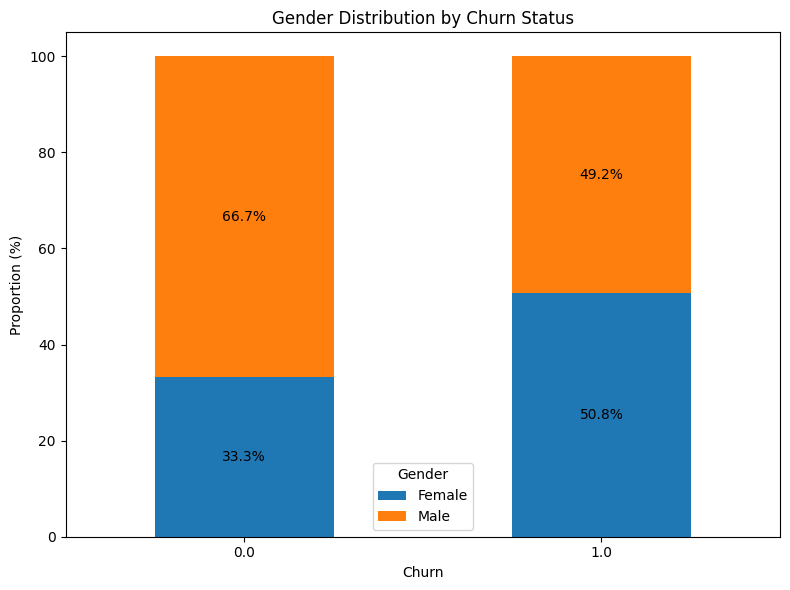

In [307]:
gender_churn = gender_churn.pivot(index='Churn', columns='Gender', values='Proportion')

# Setting up the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

gender_churn.plot(kind='bar', stacked=True, ax=ax)

ax.bar_label(ax.containers[0], label_type='center', fmt='%.1f%%')
ax.bar_label(ax.containers[1], label_type='center', fmt='%.1f%%')

ax.set_title('Gender Distribution by Churn Status')
ax.set_xlabel('Churn')
ax.set_ylabel('Proportion (%)')

plt.xticks(rotation=0)
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

In [322]:
subscription_type_churn = train.groupby(['Churn', 'Subscription Type']).size().reset_index(name='Count')
subscription_type_churn['Proportion'] = subscription_type_churn['Count']/subscription_type_churn.groupby('Churn')['Count'].transform('sum')
subscription_type_churn['Proportion'] = subscription_type_churn['Proportion'].round(3)*100

subscription_type_churn

,Churn,Subscription Type,Count,Proportion
0,0.0,Basic,59816,31.3
1,0.0,Premium,65505,34.3
2,0.0,Standard,65512,34.3
3,1.0,Basic,83210,33.3
4,1.0,Premium,83173,33.3
5,1.0,Standard,83616,33.4


And the Subscription Type doesn't give much information about churning or not

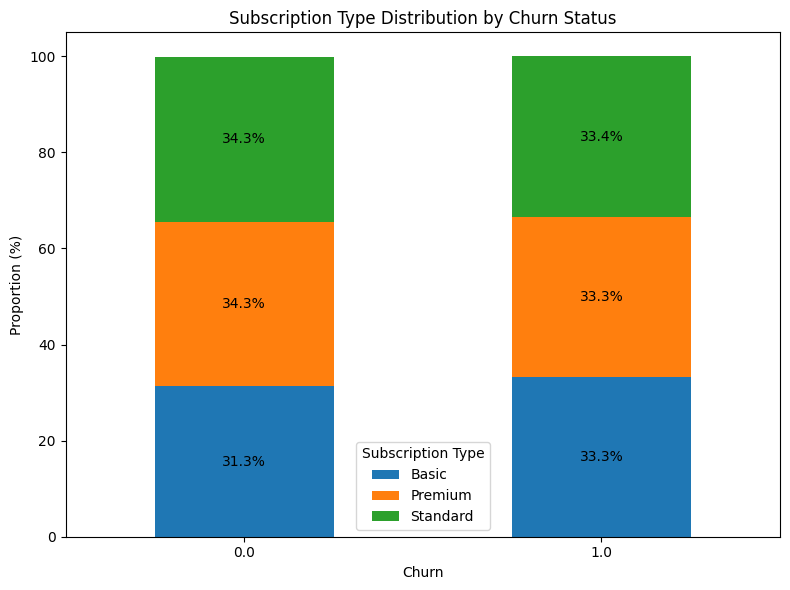

In [323]:
subscription_type_churn = subscription_type_churn.pivot(index='Churn', columns='Subscription Type', values='Proportion')

# Setting up the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

subscription_type_churn.plot(kind='bar', stacked=True, ax=ax)

ax.bar_label(ax.containers[0], label_type='center', fmt='%.1f%%')
ax.bar_label(ax.containers[1], label_type='center', fmt='%.1f%%')
ax.bar_label(ax.containers[2], label_type='center', fmt='%.1f%%')

ax.set_title('Subscription Type Distribution by Churn Status')
ax.set_xlabel('Churn')
ax.set_ylabel('Proportion (%)')

plt.xticks(rotation=0)
plt.legend(title='Subscription Type')
plt.tight_layout()
plt.show()

In [320]:
contract_churn = train.groupby(['Churn', 'Contract Length']).size().reset_index(name='Count')
contract_churn['Proportion'] = contract_churn['Count']/contract_churn.groupby('Churn')['Count'].transform('sum')
contract_churn['Proportion'] = contract_churn['Proportion'].round(3)*100

contract_churn

,Churn,Contract Length,Count,Proportion
0,0.0,Annual,95552,50.1
1,0.0,Quarterly,95281,49.9
2,1.0,Annual,81646,32.7
3,1.0,Monthly,87104,34.8
4,1.0,Quarterly,81249,32.5


On the other hand, all customers with monthly contracts are marked as churned. But we need to be careful with this data, because if churn is measured monthly, it can make customers with monthly contracts always appear as churned. 

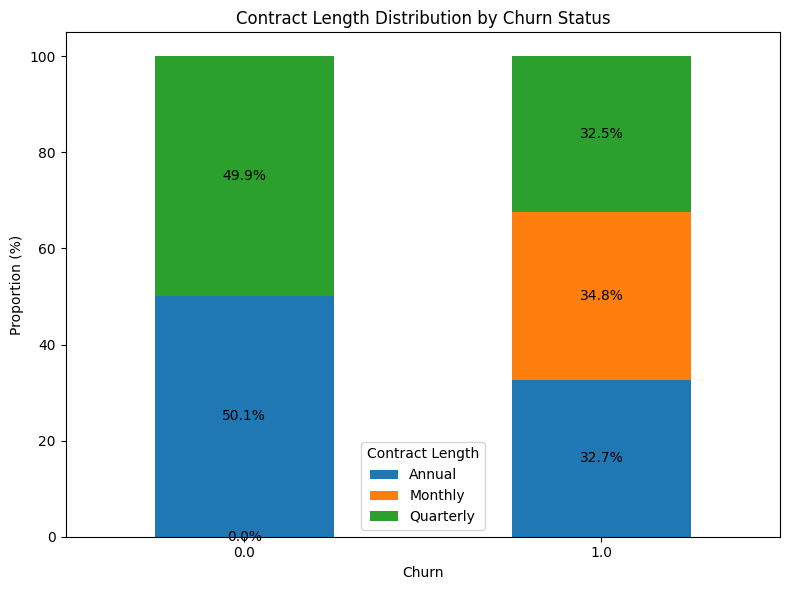

In [321]:
contract_churn = contract_churn.pivot(index='Churn', columns='Contract Length', values='Proportion')

# Setting up the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

contract_churn.plot(kind='bar', stacked=True, ax=ax)

ax.bar_label(ax.containers[0], label_type='center', fmt='%.1f%%')
ax.bar_label(ax.containers[1], label_type='center', fmt='%.1f%%')
ax.bar_label(ax.containers[2], label_type='center', fmt='%.1f%%')

ax.set_title('Contract Length Distribution by Churn Status')
ax.set_xlabel('Churn')
ax.set_ylabel('Proportion (%)')

plt.xticks(rotation=0)
plt.legend(title='Contract Length')
plt.tight_layout()
plt.show()

Looking at the numerical variables, those who __do not churn__ are:

* Less likely to make alot of support calls.

* Less likely to delay the payment for more than 20 days.

* Less likely to have a low total spending.

* Similar in Tenure, Usage Frequency and Last Interaction as those who __churn__.

* Relatively younger than those who __churn__.

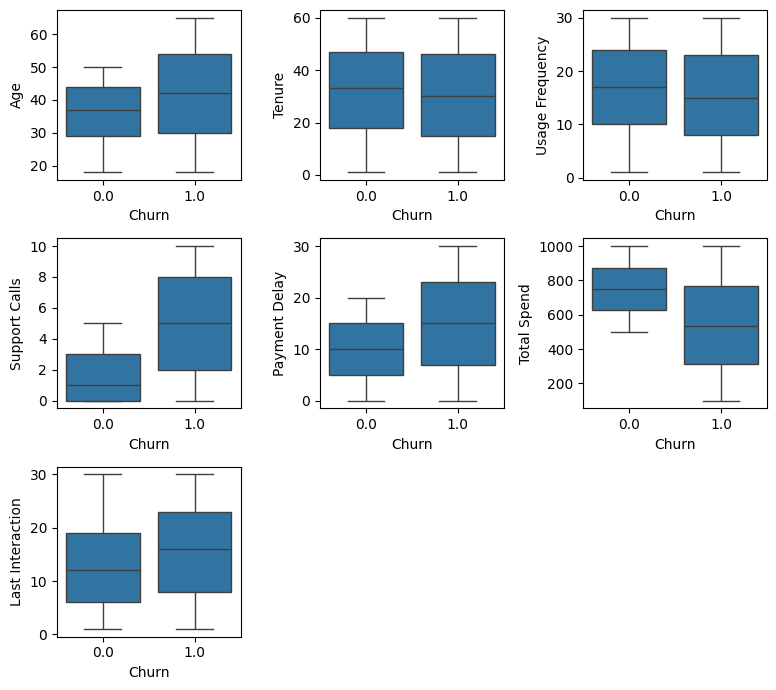

In [272]:
fig, axes = plt.subplots(3,3,figsize=(8,7))

sns.boxplot(data=train, x='Churn', y='Age', ax=axes[0,0])
sns.boxplot(data=train, x='Churn', y='Tenure', ax=axes[0,1])
sns.boxplot(data=train, x='Churn', y='Usage Frequency', ax=axes[0,2])
sns.boxplot(data=train, x='Churn', y='Support Calls', ax=axes[1,0])
sns.boxplot(data=train, x='Churn', y='Payment Delay', ax=axes[1,1])
sns.boxplot(data=train, x='Churn', y='Total Spend', ax=axes[1,2])
sns.boxplot(data=train, x='Churn', y='Last Interaction', ax=axes[2,0])

axes[2, 1].remove()
axes[2, 2].remove()

plt.tight_layout()

Now, taking a look at the correlation between the numerical variables, it is possible to see that:

* Higher values of Support Calls are associated with higher Age and Payment Delay.

* Higher values of Total Spend are associated with lower values of Support Calls and Payment Delay.

<Axes: >

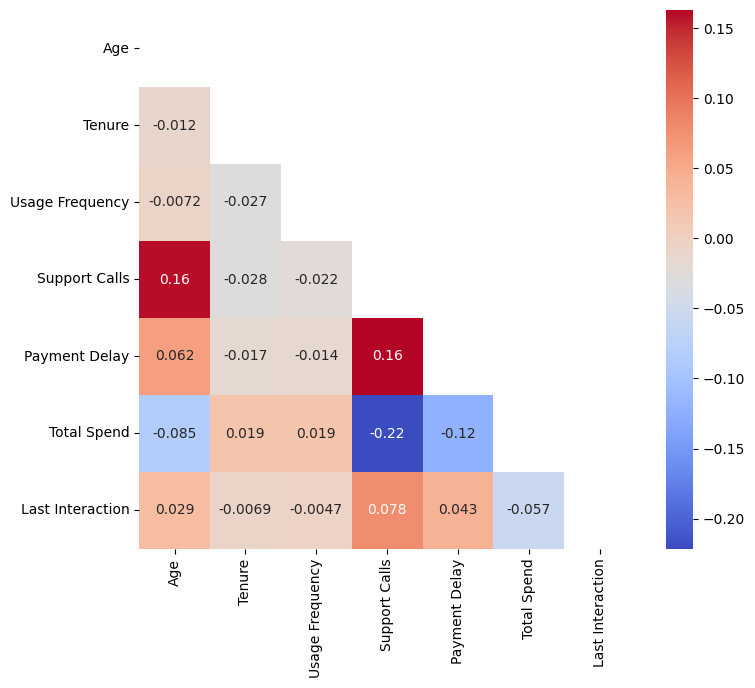

In [202]:
numeric_cols = cols = ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction']

corr_matrix = train[numeric_cols].corr()

mask = np.triu(corr_matrix)

plt.figure(figsize=(8, 7))
sns.heatmap(corr_matrix, annot=True, mask=mask, cmap='coolwarm')

# Modeling

The proportion of churn and non-churn observations are similar, with 56% of churn and 43% of non-churn: 

In [204]:
train['Churn'].value_counts(1)

Churn
1.0    0.567107
0.0    0.432893
Name: proportion, dtype: float64

If the proportions were something like 80% and 20%, we could apply a technique known as __class weighting__, which is used in classification problems with unbalanced classes. This technique assigns higher weights to observations of the minoritary class, forcing the algorithm to pay closer attention to these observations and making it less likely to make mistakes.

Because in this particular dataset the classes aren't so unbalanced, there's no need to do such thing, so we'll just skip this step.

In [205]:
train.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [206]:
X_train = train.drop(columns = ['Churn', 'CustomerID'])
y_train = train['Churn']

The proportion of churn and non-churn on the test dataset is similar:

In [170]:
test = pd.read_csv("data/customer_churn_dataset-testing-master.csv")
test['Churn'].value_counts(1)

X_test = test.drop(columns = ['Churn', 'CustomerID'])
y_test = test['Churn']

# even though there are separated datasets for test and train, I will append them, in order to shuffle during the cross-validations
X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

In [207]:
XGBoost_model = XGBClassifier(n_estimators=1000, max_depth=8, learning_rate=1e-3, random_state=123, eval_metric='error')
LightGBM_model = LGBMClassifier(n_estimators=1000, max_depth=8, num_leaves=2^8, learning_rate=10e-3, random_state=123, verbose=-1)
CatBoost_model = CatBoostClassifier(n_estimators=1000, max_depth=8, learning_rate=1e-3, random_state=123, verbose=0)
LogisticRegression_model = LogisticRegression(random_state=123, max_iter=1000)

### Cross Validation

I will use stratified cross-validation to ensure that each fold maintains the same proportion of churn and non-churn instances as the entire dataset.

In [212]:
k = 5
threshold = 0.5
folds = StratifiedKFold(n_splits=k, shuffle=True, random_state=123)

precision_list = []
recall_list = []
accuracy_list = []
f1_score_list = []
precision_recall_auc_list = []
roc_auc_list = []
confusion_matrix_total = np.zeros((2,2))

# The 'split' method will be applied to the 'folds' object, and for each fold,
# it will return the indices of the training instances and the test instances for that fold
for k, (train_index, test_index) in enumerate(folds.split(X, y)):
    print(f"------------ Fold: {k + 1} ------------")

    # training and validation sets for this fold
    X_train_fold, y_train_fold = X.iloc[train_index, :], y.iloc[train_index]
    X_test_fold, y_test_fold = X.iloc[test_index, :], y.iloc[test_index]

    encoder = CatBoostEncoder()

    cat_imputer = SimpleImputer(strategy='most_frequent')
    num_imputer = SimpleImputer(strategy='median')

    cat_pipeline = Pipeline([('encoder', encoder), ('imputer', cat_imputer)])
    num_pipeline = Pipeline([('imputer', num_imputer)])

    cat_columns = X_train_fold.select_dtypes(include = ['object']).columns
    num_columns = X_train_fold.select_dtypes(exclude = ['object']).columns

    X_train_fold[cat_columns] = cat_pipeline.fit_transform(X_train_fold[cat_columns], y_train_fold)
    X_train_fold[num_columns] = num_pipeline.fit_transform(X_train_fold[num_columns])

    X_test_fold[cat_columns] = cat_pipeline.transform(X_test_fold[cat_columns])
    X_test_fold[num_columns] = num_pipeline.transform(X_test_fold[num_columns])

    XGBoost_model.fit(X_train_fold, y_train_fold)

    y_pred_proba = XGBoost_model.predict_proba(X_test_fold)[:,1]

    y_pred = np.where(y_pred_proba > threshold, 1, 0)

    precision, recall, thresholds = precision_recall_curve(y_test_fold, y_pred)

    confusion_matrix_total += confusion_matrix(y_test_fold, y_pred)
    precision_recall_auc = auc(recall, precision)
    roc_auc = roc_auc_score(y_test_fold, y_pred_proba)
    accuracy_scores = accuracy_score(y_test_fold, y_pred)
    precision_scores = precision_score(y_test_fold, y_pred)
    recall_scores = recall_score(y_test_fold, y_pred)
    f1scores = f1_score(y_test_fold, y_pred)

    precision_list.append(precision_scores)
    recall_list.append(recall_scores)
    accuracy_list.append(accuracy_scores)
    f1_score_list.append(f1scores)
    precision_recall_auc_list.append(precision_recall_auc)
    roc_auc_list.append(roc_auc)

    print(f"Precision: {precision_scores:.3f}")
    print(f"Recall: {recall_scores:.3f}")
    print(f"Accuracy: {accuracy_scores:.3f}")
    print(f"F1 Score: {f1scores:.3f}")
    print(f"Precision-recall AUC: {precision_recall_auc:.3f}")
    print(f"ROC AUC: {roc_auc:.3f}")


    


------------ Fold: 1 ------------
Precision: 1.000
Recall: 0.946
Accuracy: 0.969
F1 Score: 0.972
Precision-recall AUC: 0.988
ROC AUC: 0.973
------------ Fold: 2 ------------
Precision: 1.000
Recall: 0.944
Accuracy: 0.968
F1 Score: 0.971
Precision-recall AUC: 0.988
ROC AUC: 0.972
------------ Fold: 3 ------------
Precision: 1.000
Recall: 0.894
Accuracy: 0.940
F1 Score: 0.944
Precision-recall AUC: 0.977
ROC AUC: 0.971
------------ Fold: 4 ------------
Precision: 1.000
Recall: 0.897
Accuracy: 0.941
F1 Score: 0.946
Precision-recall AUC: 0.978
ROC AUC: 0.972
------------ Fold: 5 ------------
Precision: 1.000
Recall: 0.944
Accuracy: 0.969
F1 Score: 0.971
Precision-recall AUC: 0.988
ROC AUC: 0.972


Taking the means:

In [213]:
precision_array = np.array(precision_list)
recall_array = np.array(recall_list)
accuracy_array = np.array(accuracy_list)
f1_score_array = np.array(f1_score_list)
precision_recall_auc_array = np.array(precision_recall_auc_list)
roc_auc_array = np.array(roc_auc_list)

mean_precision = np.mean(precision_array)
mean_recall = np.mean(recall_array)
mean_accuracy = np.mean(accuracy_array)
mean_f1_score = np.mean(f1_score_array)
mean_precision_recall_auc = np.mean(precision_recall_auc_array)
mean_roc_auc = np.mean(roc_auc_array)

std_precision = np.std(precision_array)
std_recall = np.std(recall_array)
std_accuracy = np.std(accuracy_array)
std_f1_score = np.std(f1_score_array)
std_precision_recall_auc = np.std(precision_recall_auc_array)
std_roc_auc = np.std(roc_auc_array)


metrics = ['Precision', 'Recall', 'Accuracy', 'F1 Score', 'PR AUC', 'ROC AUC']
means = [mean_precision, mean_recall, mean_accuracy, mean_f1_score, mean_precision_recall_auc, mean_roc_auc]
stds = [std_precision, std_recall, std_accuracy, std_f1_score, std_precision_recall_auc, std_roc_auc]

metrics_df = {'Metric': metrics,
           'Mean': means,
           'Standard Deviation': stds}

metrics_df = pd.DataFrame(metrics_df)

print(tabulate(metrics_df, headers='keys', floatfmt=".4f"))

    Metric       Mean    Standard Deviation
--  ---------  ------  --------------------
 0  Precision  1.0000                0.0000
 1  Recall     0.9251                0.0242
 2  Accuracy   0.9575                0.0137
 3  F1 Score   0.9609                0.0131
 4  PR AUC     0.9838                0.0052
 5  ROC AUC    0.9721                0.0007


In [246]:
# optional: bar graph
# plt.figure(figsize=(6, 4))
# plt.bar(metrics, means, yerr=stds, capsize=5, color='skyblue', edgecolor='black')
# plt.ylabel('Scores')
# plt.title('Mean and Standard Deviation of Metrics')
# plt.ylim(0, 1)
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# plt.tight_layout()
# plt.show()

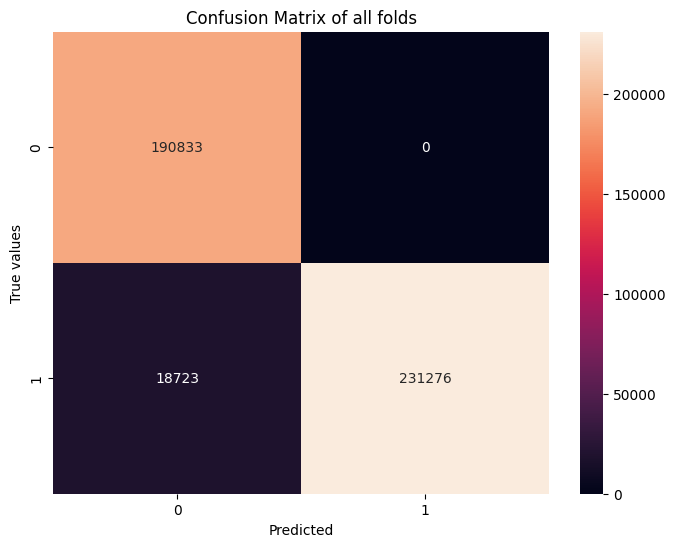

In [215]:
# confusion matrix plot
plt.figure(figsize = (8,6))
sns.heatmap(confusion_matrix_total, annot=True, fmt='g')
plt.title("Confusion Matrix of all folds")
plt.ylabel('True values')
plt.xlabel('Predicted')
plt.show()

Creating a __function__ for cross-validation, so this process can be repeated easier for other models.

In [225]:
def cross_validation(X, y, model, k, threshold):

    folds = StratifiedKFold(n_splits=k, shuffle=True, random_state=123)

    precision_list = []
    recall_list = []
    accuracy_list = []
    f1_score_list = []
    precision_recall_auc_list = []
    roc_auc_list = []
    confusion_matrix_total = np.zeros((2,2))

    # The 'split' method will be applied to the 'folds' object, and for each fold,
    # it will return the indices of the training instances and the test instances for that fold
    for k, (train_index, test_index) in enumerate(folds.split(X, y)):
        print(f"------------ Fold: {k + 1} ------------")

        # training and validation sets for this fold
        X_train_fold, y_train_fold = X.iloc[train_index, :], y.iloc[train_index]
        X_test_fold, y_test_fold = X.iloc[test_index, :], y.iloc[test_index]

        encoder = CatBoostEncoder()

        cat_imputer = SimpleImputer(strategy='most_frequent')
        num_imputer = SimpleImputer(strategy='median')

        cat_pipeline = Pipeline([('encoder', encoder), ('imputer', cat_imputer)])
        num_pipeline = Pipeline([('imputer', num_imputer)])

        cat_columns = X_train_fold.select_dtypes(include = ['object']).columns
        num_columns = X_train_fold.select_dtypes(exclude = ['object']).columns

        X_train_fold[cat_columns] = cat_pipeline.fit_transform(X_train_fold[cat_columns], y_train_fold)
        X_train_fold[num_columns] = num_pipeline.fit_transform(X_train_fold[num_columns])

        X_test_fold[cat_columns] = cat_pipeline.transform(X_test_fold[cat_columns])
        X_test_fold[num_columns] = num_pipeline.transform(X_test_fold[num_columns])

        model.fit(X_train_fold, y_train_fold)

        y_pred_proba = model.predict_proba(X_test_fold)[:,1]

        y_pred = np.where(y_pred_proba > threshold, 1, 0)

        precision, recall, thresholds = precision_recall_curve(y_test_fold, y_pred)

        confusion_matrix_total += confusion_matrix(y_test_fold, y_pred)
        precision_recall_auc = auc(recall, precision)
        roc_auc = roc_auc_score(y_test_fold, y_pred_proba)
        accuracy_scores = accuracy_score(y_test_fold, y_pred)
        precision_scores = precision_score(y_test_fold, y_pred)
        recall_scores = recall_score(y_test_fold, y_pred)
        f1scores = f1_score(y_test_fold, y_pred)

        precision_list.append(precision_scores)
        recall_list.append(recall_scores)
        accuracy_list.append(accuracy_scores)
        f1_score_list.append(f1scores)
        precision_recall_auc_list.append(precision_recall_auc)
        roc_auc_list.append(roc_auc)

        print(f"Precision: {precision_scores:.3f}")
        print(f"Recall: {recall_scores:.3f}")
        print(f"Accuracy: {accuracy_scores:.3f}")
        print(f"F1 Score: {f1scores:.3f}")
        print(f"Precision-recall AUC: {precision_recall_auc:.3f}")
        print(f"ROC AUC: {roc_auc:.3f}")

    # calculating the means and stds
    precision_array = np.array(precision_list)
    recall_array = np.array(recall_list)
    accuracy_array = np.array(accuracy_list)
    f1_score_array = np.array(f1_score_list)
    precision_recall_auc_array = np.array(precision_recall_auc_list)
    roc_auc_array = np.array(roc_auc_list)

    mean_precision = np.mean(precision_array)
    mean_recall = np.mean(recall_array)
    mean_accuracy = np.mean(accuracy_array)
    mean_f1_score = np.mean(f1_score_array)
    mean_precision_recall_auc = np.mean(precision_recall_auc_array)
    mean_roc_auc = np.mean(roc_auc_array)

    std_precision = np.std(precision_array)
    std_recall = np.std(recall_array)
    std_accuracy = np.std(accuracy_array)
    std_f1_score = np.std(f1_score_array)
    std_precision_recall_auc = np.std(precision_recall_auc_array)
    std_roc_auc = np.std(roc_auc_array)


    metrics = ['Precision', 'Recall', 'Accuracy', 'F1 Score', 'PR AUC', 'ROC AUC']
    means = [mean_precision, mean_recall, mean_accuracy, mean_f1_score, mean_precision_recall_auc, mean_roc_auc]
    stds = [std_precision, std_recall, std_accuracy, std_f1_score, std_precision_recall_auc, std_roc_auc]

    metrics_df = {'Metric': metrics,
            'Mean': means,
            'Standard Deviation': stds}

    metrics_df = pd.DataFrame(metrics_df)

    print(tabulate(metrics_df, headers='keys', floatfmt=".4f"))

    # confusion matrix (in percentage)
    conf_matrix_percent = confusion_matrix_total / np.sum(confusion_matrix_total)
    plt.figure(figsize = (8,6))
    # sns.heatmap(confusion_matrix_total, annot=True, fmt='g')
    sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%')
    plt.title("Confusion Matrix of all folds")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


## XGBoost

------------ Fold: 1 ------------
Precision: 1.000
Recall: 0.946
Accuracy: 0.969
F1 Score: 0.972
Precision-recall AUC: 0.988
ROC AUC: 0.973
------------ Fold: 2 ------------
Precision: 1.000
Recall: 0.944
Accuracy: 0.968
F1 Score: 0.971
Precision-recall AUC: 0.988
ROC AUC: 0.972
------------ Fold: 3 ------------
Precision: 1.000
Recall: 0.894
Accuracy: 0.940
F1 Score: 0.944
Precision-recall AUC: 0.977
ROC AUC: 0.971
------------ Fold: 4 ------------
Precision: 1.000
Recall: 0.897
Accuracy: 0.941
F1 Score: 0.946
Precision-recall AUC: 0.978
ROC AUC: 0.972
------------ Fold: 5 ------------
Precision: 1.000
Recall: 0.944
Accuracy: 0.969
F1 Score: 0.971
Precision-recall AUC: 0.988
ROC AUC: 0.972
    Metric       Mean    Standard Deviation
--  ---------  ------  --------------------
 0  Precision  1.0000                0.0000
 1  Recall     0.9251                0.0242
 2  Accuracy   0.9575                0.0137
 3  F1 Score   0.9609                0.0131
 4  PR AUC     0.9838               

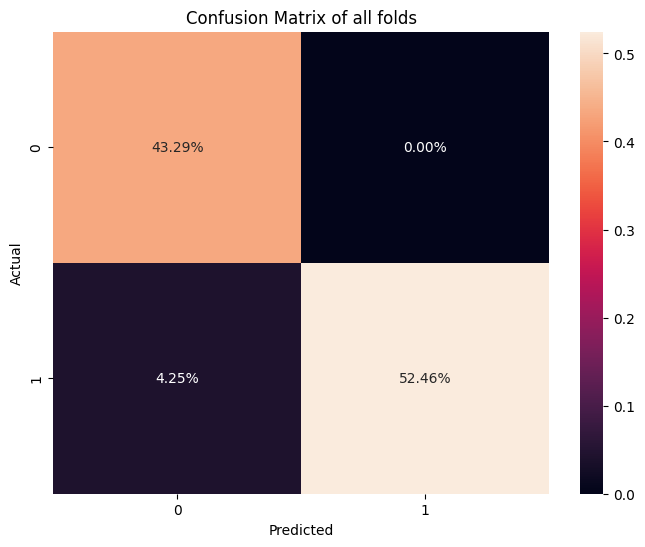

In [228]:
cross_validation(X, y, XGBoost_model, k=5, threshold=0.5)

## LightGBM

------------ Fold: 1 ------------
Precision: 1.000
Recall: 0.602
Accuracy: 0.774
F1 Score: 0.751
Precision-recall AUC: 0.914
ROC AUC: 0.995
------------ Fold: 2 ------------
Precision: 1.000
Recall: 0.536
Accuracy: 0.737
F1 Score: 0.698
Precision-recall AUC: 0.900
ROC AUC: 0.996
------------ Fold: 3 ------------
Precision: 1.000
Recall: 0.526
Accuracy: 0.731
F1 Score: 0.689
Precision-recall AUC: 0.897
ROC AUC: 0.995
------------ Fold: 4 ------------
Precision: 1.000
Recall: 0.497
Accuracy: 0.715
F1 Score: 0.664
Precision-recall AUC: 0.891
ROC AUC: 0.995
------------ Fold: 5 ------------
Precision: 1.000
Recall: 0.446
Accuracy: 0.686
F1 Score: 0.617
Precision-recall AUC: 0.880
ROC AUC: 0.996
    Metric       Mean    Standard Deviation
--  ---------  ------  --------------------
 0  Precision  1.0000                0.0000
 1  Recall     0.5214                0.0508
 2  Accuracy   0.7286                0.0288
 3  F1 Score   0.6840                0.0438
 4  PR AUC     0.8964               

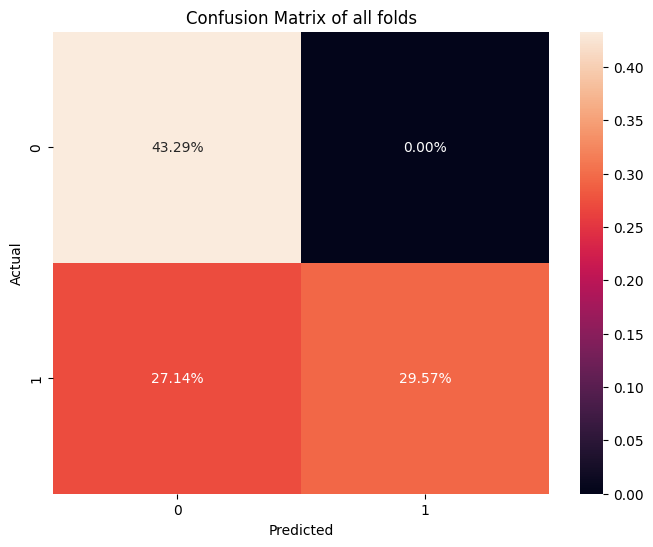

In [227]:
cross_validation(X, y, LightGBM_model, k=5, threshold=0.5)

## CatBoost

------------ Fold: 1 ------------
Precision: 1.000
Recall: 0.862
Accuracy: 0.922
F1 Score: 0.926
Precision-recall AUC: 0.970
ROC AUC: 0.994
------------ Fold: 2 ------------
Precision: 1.000
Recall: 0.862
Accuracy: 0.922
F1 Score: 0.926
Precision-recall AUC: 0.970
ROC AUC: 0.993
------------ Fold: 3 ------------
Precision: 1.000
Recall: 0.876
Accuracy: 0.930
F1 Score: 0.934
Precision-recall AUC: 0.973
ROC AUC: 0.993
------------ Fold: 4 ------------
Precision: 1.000
Recall: 0.877
Accuracy: 0.930
F1 Score: 0.935
Precision-recall AUC: 0.973
ROC AUC: 0.993
------------ Fold: 5 ------------
Precision: 1.000
Recall: 0.861
Accuracy: 0.921
F1 Score: 0.925
Precision-recall AUC: 0.970
ROC AUC: 0.993
    Metric       Mean    Standard Deviation
--  ---------  ------  --------------------
 0  Precision  1.0000                0.0000
 1  Recall     0.8678                0.0073
 2  Accuracy   0.9250                0.0041
 3  F1 Score   0.9292                0.0042
 4  PR AUC     0.9714               

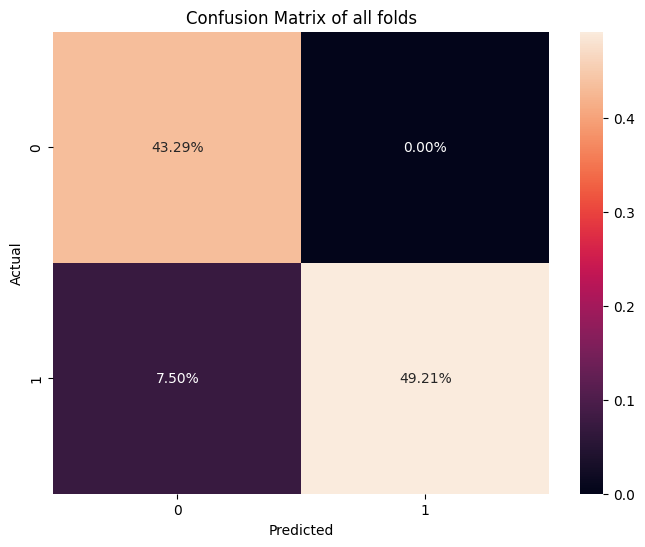

In [229]:
cross_validation(X, y, CatBoost_model, k=5, threshold=0.5)

## Logistic Regression

------------ Fold: 1 ------------
Precision: 1.000
Recall: 0.005
Accuracy: 0.436
F1 Score: 0.009
Precision-recall AUC: 0.785
ROC AUC: 0.941
------------ Fold: 2 ------------
Precision: 1.000
Recall: 0.004
Accuracy: 0.435
F1 Score: 0.007
Precision-recall AUC: 0.784
ROC AUC: 0.940
------------ Fold: 3 ------------
Precision: 1.000
Recall: 0.005
Accuracy: 0.436
F1 Score: 0.010
Precision-recall AUC: 0.785
ROC AUC: 0.942
------------ Fold: 4 ------------
Precision: 1.000
Recall: 0.004
Accuracy: 0.435
F1 Score: 0.008
Precision-recall AUC: 0.784
ROC AUC: 0.942
------------ Fold: 5 ------------
Precision: 1.000
Recall: 0.003
Accuracy: 0.434
F1 Score: 0.005
Precision-recall AUC: 0.784
ROC AUC: 0.939
    Metric       Mean    Standard Deviation
--  ---------  ------  --------------------
 0  Precision  1.0000                0.0000
 1  Recall     0.0040                0.0008
 2  Accuracy   0.4351                0.0005
 3  F1 Score   0.0079                0.0017
 4  PR AUC     0.7844               

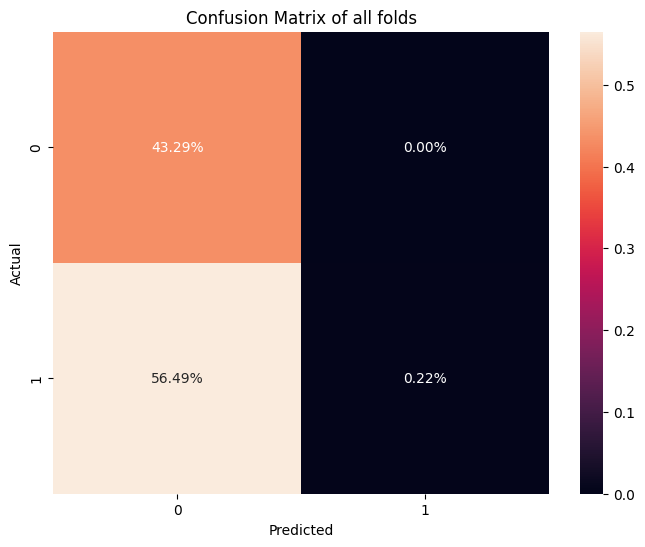

In [230]:
cross_validation(X, y, LogisticRegression_model, k=5, threshold=0.5)

# Hyperparameter tuning

When predicting churn, the cost of false negatives is high, so we might want to use the model who has the better value for the __Recall__ metric. As it was possible to see above, the Logistic Regression and LightGBM models performed incredibly bad in Recall. So, it is reasonable to try to improve the XGBoost and Catboost models, which did better in this metric.

There are several methods to do hyperparameter tuning. I'll go with the [Bayesian Optimization](https://medium.com/@becaye-balde/bayesian-sorcery-for-hyperparameter-optimization-using-optuna-1ee4517e89a) with the Optuna package.

### XGBoost

In [234]:
def hyperparameter_tuning(trial, k=5, threshold=0.5):

    # hyperparameter tuning
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    subsample = trial.suggest_float('subsample', 0, 1, step=0.1)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0, 1, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 20)
    n_estimators = trial.suggest_int('n_estimators', 100, 2000, step = 100)


    folds = StratifiedKFold(n_splits=k, shuffle=True, random_state=123)

    precision_list = []
    recall_list = []
    accuracy_list = []
    f1_score_list = []
    precision_recall_auc_list = []
    roc_auc_list = []
    confusion_matrix_total = np.zeros((2,2))

    # The 'split' method will be applied to the 'folds' object, and for each fold,
    # it will return the indices of the training instances and the test instances for that fold
    for k, (train_index, test_index) in enumerate(folds.split(X, y)):
        print(f"------------ Fold: {k + 1} ------------")

        # training and validation sets for this fold
        X_train_fold, y_train_fold = X.iloc[train_index, :], y.iloc[train_index]
        X_test_fold, y_test_fold = X.iloc[test_index, :], y.iloc[test_index]

        encoder = CatBoostEncoder()

        cat_imputer = SimpleImputer(strategy='most_frequent')
        num_imputer = SimpleImputer(strategy='median')

        cat_pipeline = Pipeline([('encoder', encoder), ('imputer', cat_imputer)])
        num_pipeline = Pipeline([('imputer', num_imputer)])

        cat_columns = X_train_fold.select_dtypes(include = ['object']).columns
        num_columns = X_train_fold.select_dtypes(exclude = ['object']).columns

        X_train_fold[cat_columns] = cat_pipeline.fit_transform(X_train_fold[cat_columns], y_train_fold)
        X_train_fold[num_columns] = num_pipeline.fit_transform(X_train_fold[num_columns])

        X_test_fold[cat_columns] = cat_pipeline.transform(X_test_fold[cat_columns])
        X_test_fold[num_columns] = num_pipeline.transform(X_test_fold[num_columns])

        XGBoost_model = XGBClassifier(
            learning_rate = learning_rate,
            max_depth = max_depth,
            subsample = subsample,
            colsample_bytree = colsample_bytree,
            min_child_weight = min_child_weight,
            n_estimators = n_estimators,
            random_state = 123,
            eval_metric='error'
        )
        XGBoost_model.fit(X_train_fold, y_train_fold)

        y_pred_proba = XGBoost_model.predict_proba(X_test_fold)[:,1]

        y_pred = np.where(y_pred_proba > threshold, 1, 0)

        precision, recall, thresholds = precision_recall_curve(y_test_fold, y_pred)

        confusion_matrix_total += confusion_matrix(y_test_fold, y_pred)
        precision_recall_auc = auc(recall, precision)
        roc_auc = roc_auc_score(y_test_fold, y_pred_proba)
        accuracy_scores = accuracy_score(y_test_fold, y_pred)
        precision_scores = precision_score(y_test_fold, y_pred)
        recall_scores = recall_score(y_test_fold, y_pred)
        f1scores = f1_score(y_test_fold, y_pred)

        precision_list.append(precision_scores)
        recall_list.append(recall_scores)
        accuracy_list.append(accuracy_scores)
        f1_score_list.append(f1scores)
        precision_recall_auc_list.append(precision_recall_auc)
        roc_auc_list.append(roc_auc)

    # calculating the means and stds
    precision_array = np.array(precision_list)
    recall_array = np.array(recall_list)
    accuracy_array = np.array(accuracy_list)
    f1_score_array = np.array(f1_score_list)
    precision_recall_auc_array = np.array(precision_recall_auc_list)
    roc_auc_array = np.array(roc_auc_list)

    mean_precision = np.mean(precision_array)
    mean_recall = np.mean(recall_array)
    mean_accuracy = np.mean(accuracy_array)
    mean_f1_score = np.mean(f1_score_array)
    mean_precision_recall_auc = np.mean(precision_recall_auc_array)
    mean_roc_auc = np.mean(roc_auc_array)

    return mean_recall

study = opt.create_study(direction='maximize')
study.optimize(hyperparameter_tuning, n_trials=20)

[I 2024-09-29 22:19:01,076] A new study created in memory with name: no-name-e86dcf83-80eb-458a-8fa5-89f0deafe1c4


------------ Fold: 1 ------------
------------ Fold: 2 ------------
------------ Fold: 3 ------------
------------ Fold: 4 ------------
------------ Fold: 5 ------------


[I 2024-09-29 22:23:07,674] Trial 0 finished with value: 0.8875395367107342 and parameters: {'learning_rate': 0.044408470725720794, 'max_depth': 15, 'subsample': 0.5, 'colsample_bytree': 0.4, 'min_child_weight': 5, 'n_estimators': 1900}. Best is trial 0 with value: 0.8875395367107342.


------------ Fold: 1 ------------
------------ Fold: 2 ------------
------------ Fold: 3 ------------
------------ Fold: 4 ------------
------------ Fold: 5 ------------


[I 2024-09-29 22:25:53,516] Trial 1 finished with value: 0.28208112194243884 and parameters: {'learning_rate': 0.007173623878729457, 'max_depth': 11, 'subsample': 0.8, 'colsample_bytree': 0.1, 'min_child_weight': 5, 'n_estimators': 1400}. Best is trial 0 with value: 0.8875395367107342.


------------ Fold: 1 ------------
------------ Fold: 2 ------------
------------ Fold: 3 ------------
------------ Fold: 4 ------------
------------ Fold: 5 ------------


[I 2024-09-29 22:29:02,601] Trial 2 finished with value: 0.6033544193283865 and parameters: {'learning_rate': 0.014235359496631773, 'max_depth': 17, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.2, 'min_child_weight': 19, 'n_estimators': 1300}. Best is trial 0 with value: 0.8875395367107342.


------------ Fold: 1 ------------
------------ Fold: 2 ------------
------------ Fold: 3 ------------
------------ Fold: 4 ------------
------------ Fold: 5 ------------


[I 2024-09-29 22:31:50,236] Trial 3 finished with value: 0.48485402556051127 and parameters: {'learning_rate': 0.004488177429860714, 'max_depth': 13, 'subsample': 0.4, 'colsample_bytree': 0.5, 'min_child_weight': 11, 'n_estimators': 1500}. Best is trial 0 with value: 0.8875395367107342.


------------ Fold: 1 ------------
------------ Fold: 2 ------------
------------ Fold: 3 ------------
------------ Fold: 4 ------------
------------ Fold: 5 ------------


[I 2024-09-29 22:33:33,979] Trial 4 finished with value: 0.3484173885077702 and parameters: {'learning_rate': 0.022326660069983257, 'max_depth': 14, 'subsample': 0.1, 'colsample_bytree': 1.0, 'min_child_weight': 13, 'n_estimators': 1200}. Best is trial 0 with value: 0.8875395367107342.


------------ Fold: 1 ------------
------------ Fold: 2 ------------
------------ Fold: 3 ------------
------------ Fold: 4 ------------
------------ Fold: 5 ------------


[I 2024-09-29 22:36:03,988] Trial 5 finished with value: 0.38286202100042005 and parameters: {'learning_rate': 0.0012969168274197965, 'max_depth': 7, 'subsample': 0.2, 'colsample_bytree': 1.0, 'min_child_weight': 8, 'n_estimators': 1700}. Best is trial 0 with value: 0.8875395367107342.


------------ Fold: 1 ------------
------------ Fold: 2 ------------
------------ Fold: 3 ------------
------------ Fold: 4 ------------
------------ Fold: 5 ------------


[I 2024-09-29 22:38:07,826] Trial 6 finished with value: 0.7568029699793997 and parameters: {'learning_rate': 0.02879202305532219, 'max_depth': 3, 'subsample': 0.2, 'colsample_bytree': 0.30000000000000004, 'min_child_weight': 19, 'n_estimators': 1500}. Best is trial 0 with value: 0.8875395367107342.


------------ Fold: 1 ------------
------------ Fold: 2 ------------
------------ Fold: 3 ------------
------------ Fold: 4 ------------
------------ Fold: 5 ------------


[I 2024-09-29 22:38:54,713] Trial 7 finished with value: 0.23857301426028518 and parameters: {'learning_rate': 0.011274649000648944, 'max_depth': 4, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.2, 'min_child_weight': 13, 'n_estimators': 500}. Best is trial 0 with value: 0.8875395367107342.


------------ Fold: 1 ------------
------------ Fold: 2 ------------
------------ Fold: 3 ------------
------------ Fold: 4 ------------
------------ Fold: 5 ------------


[I 2024-09-29 22:40:22,814] Trial 8 finished with value: 0.4714937685153703 and parameters: {'learning_rate': 0.03779997842505536, 'max_depth': 8, 'subsample': 1.0, 'colsample_bytree': 0.1, 'min_child_weight': 5, 'n_estimators': 1000}. Best is trial 0 with value: 0.8875395367107342.


------------ Fold: 1 ------------
------------ Fold: 2 ------------
------------ Fold: 3 ------------
------------ Fold: 4 ------------
------------ Fold: 5 ------------


[I 2024-09-29 22:41:47,588] Trial 9 finished with value: 0.3615138306766136 and parameters: {'learning_rate': 0.003109757810994903, 'max_depth': 17, 'subsample': 0.5, 'colsample_bytree': 0.4, 'min_child_weight': 18, 'n_estimators': 600}. Best is trial 0 with value: 0.8875395367107342.


------------ Fold: 1 ------------
------------ Fold: 2 ------------
------------ Fold: 3 ------------
------------ Fold: 4 ------------
------------ Fold: 5 ------------


[I 2024-09-29 22:43:23,866] Trial 10 finished with value: 1.0 and parameters: {'learning_rate': 0.07326870624786452, 'max_depth': 20, 'subsample': 0.0, 'colsample_bytree': 0.7000000000000001, 'min_child_weight': 1, 'n_estimators': 1900}. Best is trial 10 with value: 1.0.


------------ Fold: 1 ------------
------------ Fold: 2 ------------
------------ Fold: 3 ------------
------------ Fold: 4 ------------
------------ Fold: 5 ------------


[I 2024-09-29 22:44:55,865] Trial 11 finished with value: 1.0 and parameters: {'learning_rate': 0.08683433885869045, 'max_depth': 19, 'subsample': 0.0, 'colsample_bytree': 0.7000000000000001, 'min_child_weight': 1, 'n_estimators': 2000}. Best is trial 10 with value: 1.0.


------------ Fold: 1 ------------
------------ Fold: 2 ------------
------------ Fold: 3 ------------
------------ Fold: 4 ------------
------------ Fold: 5 ------------


[I 2024-09-29 22:46:22,837] Trial 12 finished with value: 1.0 and parameters: {'learning_rate': 0.09526048343785581, 'max_depth': 20, 'subsample': 0.0, 'colsample_bytree': 0.7000000000000001, 'min_child_weight': 1, 'n_estimators': 2000}. Best is trial 10 with value: 1.0.


------------ Fold: 1 ------------
------------ Fold: 2 ------------
------------ Fold: 3 ------------
------------ Fold: 4 ------------
------------ Fold: 5 ------------


[I 2024-09-29 22:47:48,848] Trial 13 finished with value: 1.0 and parameters: {'learning_rate': 0.08997708011828569, 'max_depth': 20, 'subsample': 0.0, 'colsample_bytree': 0.7000000000000001, 'min_child_weight': 1, 'n_estimators': 2000}. Best is trial 10 with value: 1.0.


------------ Fold: 1 ------------
------------ Fold: 2 ------------
------------ Fold: 3 ------------
------------ Fold: 4 ------------
------------ Fold: 5 ------------


[I 2024-09-29 22:48:04,421] Trial 14 finished with value: 1.0 and parameters: {'learning_rate': 0.05365106127341215, 'max_depth': 18, 'subsample': 0.0, 'colsample_bytree': 0.7000000000000001, 'min_child_weight': 3, 'n_estimators': 200}. Best is trial 10 with value: 1.0.


------------ Fold: 1 ------------
------------ Fold: 2 ------------
------------ Fold: 3 ------------
------------ Fold: 4 ------------
------------ Fold: 5 ------------


[I 2024-09-29 22:50:27,585] Trial 15 finished with value: 0.559902328206564 and parameters: {'learning_rate': 0.0650886035087504, 'max_depth': 20, 'subsample': 0.2, 'colsample_bytree': 0.8, 'min_child_weight': 7, 'n_estimators': 1700}. Best is trial 10 with value: 1.0.


------------ Fold: 1 ------------
------------ Fold: 2 ------------
------------ Fold: 3 ------------
------------ Fold: 4 ------------
------------ Fold: 5 ------------


[I 2024-09-29 22:52:02,247] Trial 16 finished with value: 0.6325704349286985 and parameters: {'learning_rate': 0.019124155348874933, 'max_depth': 11, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.8, 'min_child_weight': 3, 'n_estimators': 900}. Best is trial 10 with value: 1.0.


------------ Fold: 1 ------------
------------ Fold: 2 ------------
------------ Fold: 3 ------------
------------ Fold: 4 ------------
------------ Fold: 5 ------------


[I 2024-09-29 22:55:23,883] Trial 17 finished with value: 0.9501237289545792 and parameters: {'learning_rate': 0.09656671871262247, 'max_depth': 16, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.6000000000000001, 'min_child_weight': 1, 'n_estimators': 1700}. Best is trial 10 with value: 1.0.


------------ Fold: 1 ------------
------------ Fold: 2 ------------
------------ Fold: 3 ------------
------------ Fold: 4 ------------
------------ Fold: 5 ------------


[I 2024-09-29 22:58:10,714] Trial 18 finished with value: 0.34960140210804214 and parameters: {'learning_rate': 0.030261149972103385, 'max_depth': 18, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 8, 'n_estimators': 1700}. Best is trial 10 with value: 1.0.


------------ Fold: 1 ------------
------------ Fold: 2 ------------
------------ Fold: 3 ------------
------------ Fold: 4 ------------
------------ Fold: 5 ------------


[I 2024-09-29 23:01:27,130] Trial 19 finished with value: 0.5279700705214104 and parameters: {'learning_rate': 0.007261370942116598, 'max_depth': 7, 'subsample': 0.1, 'colsample_bytree': 0.5, 'min_child_weight': 16, 'n_estimators': 1900}. Best is trial 10 with value: 1.0.


In [242]:
params = {'learning_rate': 0.07326870624786452, 'max_depth': 20, 'subsample': 0.0, 'colsample_bytree': 0.7000000000000001, 'min_child_weight': 1, 'n_estimators': 1900}

------------ Fold: 1 ------------
Precision: 0.567
Recall: 1.000
Accuracy: 0.567
F1 Score: 0.724
Precision-recall AUC: 0.784
ROC AUC: 0.500
------------ Fold: 2 ------------
Precision: 0.567
Recall: 1.000
Accuracy: 0.567
F1 Score: 0.724
Precision-recall AUC: 0.784
ROC AUC: 0.500
------------ Fold: 3 ------------
Precision: 0.567
Recall: 1.000
Accuracy: 0.567
F1 Score: 0.724
Precision-recall AUC: 0.784
ROC AUC: 0.500
------------ Fold: 4 ------------
Precision: 0.567
Recall: 1.000
Accuracy: 0.567
F1 Score: 0.724
Precision-recall AUC: 0.784
ROC AUC: 0.500
------------ Fold: 5 ------------
Precision: 0.567
Recall: 1.000
Accuracy: 0.567
F1 Score: 0.724
Precision-recall AUC: 0.784
ROC AUC: 0.500
    Metric       Mean    Standard Deviation
--  ---------  ------  --------------------
 0  Precision  0.5671                0.0000
 1  Recall     1.0000                0.0000
 2  Accuracy   0.5671                0.0000
 3  F1 Score   0.7238                0.0000
 4  PR AUC     0.7836               

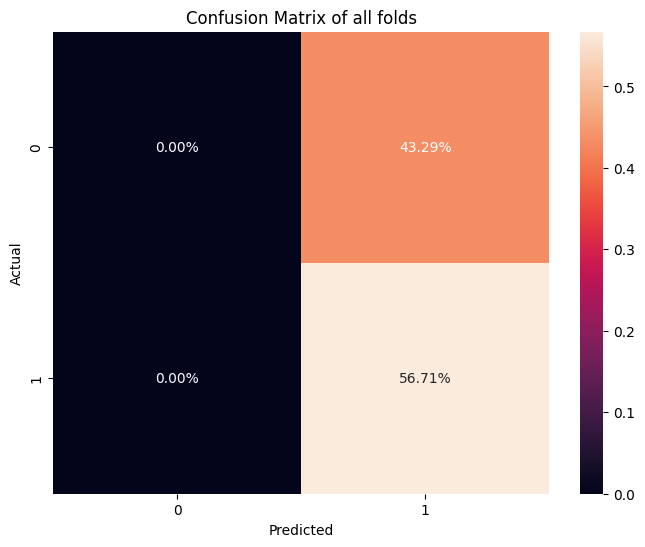

In [243]:
XGBoost_model = XGBClassifier(num_leaves=2^8, random_state=123, **params)
cross_validation(X, y, XGBoost_model, k=5, threshold=0.5)

When the parameters are set to achieve a recall of 1, the model predicts that __everyone will churn__. As a result, there are no false negatives, and recall reaches 100%. However, this can be problematic for marketing campaigns or promotions aimed at customers with a higher likelihood of churn. Instead of targeting those specific customers, the campaigns will be delivered to everyone, leading to a significant waste of time and resources, as opposed to only missing a few false negatives.

In this scenario, it is probably a better option better to use the set of parameters that achieve a high recall, but less than 1. The trial 17 reached a Recall of 0.95, keeping good values for accuracy and precision as well:

------------ Fold: 1 ------------
Precision: 1.000
Recall: 0.957
Accuracy: 0.976
F1 Score: 0.978
Precision-recall AUC: 0.991
ROC AUC: 0.995
------------ Fold: 2 ------------
Precision: 1.000
Recall: 0.955
Accuracy: 0.975
F1 Score: 0.977
Precision-recall AUC: 0.990
ROC AUC: 0.996
------------ Fold: 3 ------------
Precision: 1.000
Recall: 0.953
Accuracy: 0.973
F1 Score: 0.976
Precision-recall AUC: 0.990
ROC AUC: 0.995
------------ Fold: 4 ------------
Precision: 1.000
Recall: 0.953
Accuracy: 0.973
F1 Score: 0.976
Precision-recall AUC: 0.990
ROC AUC: 0.996
------------ Fold: 5 ------------
Precision: 1.000
Recall: 0.932
Accuracy: 0.962
F1 Score: 0.965
Precision-recall AUC: 0.985
ROC AUC: 0.996
    Metric       Mean    Standard Deviation
--  ---------  ------  --------------------
 0  Precision  1.0000                0.0000
 1  Recall     0.9501                0.0091
 2  Accuracy   0.9717                0.0051
 3  F1 Score   0.9744                0.0048
 4  PR AUC     0.9892               

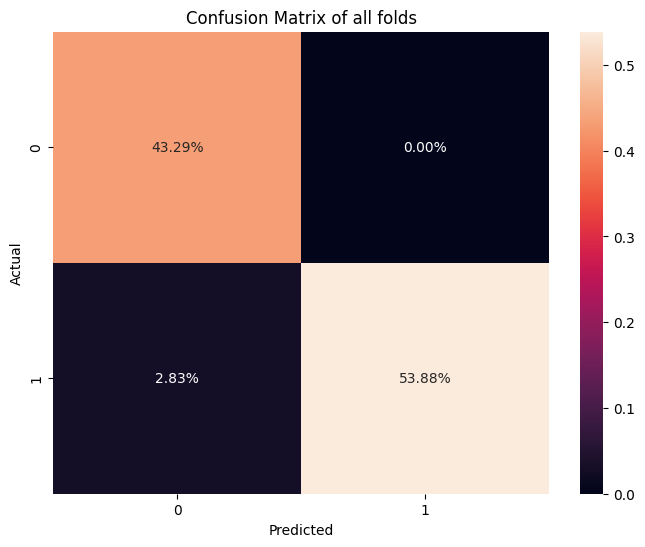

In [241]:
params = {'learning_rate': 0.09656671871262247, 'max_depth': 16, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.6000000000000001, 'min_child_weight': 1, 'n_estimators': 1700}
XGBoost_model = XGBClassifier(num_leaves=2^8, random_state=123, **params)
cross_validation(X, y, XGBoost_model, k=5, threshold=0.5)